# Deciphering Code with Character-Level RNN





## Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
df = pd.read_csv('../data/CaesarCipher.csv')
df

,Passwords,ciphertext,key
0,123456,567890,6
1,12345,56789,6
2,123456789,789012345,14
3,password,bmeeiadp,14
4,iloveyou,nqtajdtz,21
...,...,...,...
14343471,"xCvBnM,",uZsYkJ,3
14343472,ie168,fb835,3
14343473,abygurl69,kliqebv03,16
14343474,a6_123,r7234,9


C:\Users\Ashwin\miniconda3\envs\Neural-Cryptanalysis\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='key', ylabel='count'>

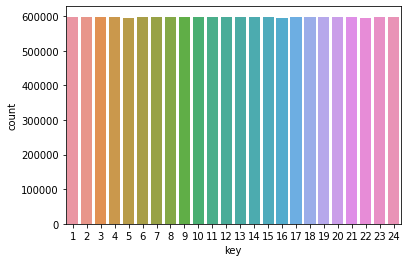

In [7]:
sns.countplot(df['key'])

In [8]:
df = df.dropna()[:120000]

C:\Users\Ashwin\miniconda3\envs\Neural-Cryptanalysis\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='key', ylabel='count'>

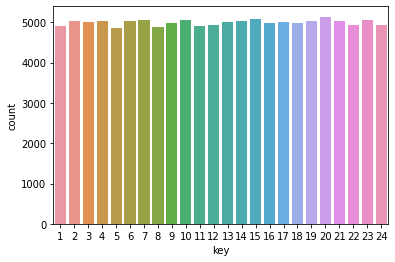

In [9]:
sns.countplot(df['key'])


In [7]:
df['Passwords'].apply(str)
df['ciphertext'].apply(str)
df

,Passwords,ciphertext,key
0,123456,567890,6
1,12345,56789,6
2,123456789,789012345,14
3,password,bmeeiadp,14
4,iloveyou,nqtajdtz,21
...,...,...,...
120022,270796,947463,3
120023,270783,947450,13
120024,27061992,16950881,1
120025,27061985,83627541,14


## Preprocessing Data

In [8]:
def tokenize(x):
    x_tk = Tokenizer(char_level=True)
    x_tk.fit_on_texts(x)                 

    return x_tk.texts_to_sequences(x), x_tk

def pad(x, length=None):
    if length is None:
        length = max([len(sentence) for sentence in x])
    
    return pad_sequences(x, maxlen=length, padding="post", truncating="post",)

### Preprocess Pipeline

In [9]:
def preprocess(x, y):
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk

In [10]:
preproc_code_sentences, preproc_plaintext_sentences, code_tokenizer, plaintext_tokenizer = preprocess(df['Passwords'], df['ciphertext'])

print('Data Preprocessed')

Data Preprocessed


In [11]:
preproc_code_sentences[0]

array([ 3, 12, 22, 26, 27, 29,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0])

In [12]:
len(code_tokenizer.word_index)+1

78

In [13]:
len(plaintext_tokenizer.word_index)+1

41

In [14]:
plaintext_tokenizer.word_index

{'1': 1,
 'x': 2,
 'w': 3,
 'j': 4,
 'f': 5,
 'z': 6,
 'q': 7,
 'k': 8,
 'v': 9,
 'h': 10,
 'y': 11,
 'b': 12,
 'g': 13,
 'c': 14,
 'd': 15,
 'u': 16,
 'p': 17,
 't': 18,
 'm': 19,
 'l': 20,
 'n': 21,
 's': 22,
 'i': 23,
 'r': 24,
 '0': 25,
 'o': 26,
 'e': 27,
 '2': 28,
 'a': 29,
 '9': 30,
 '8': 31,
 '3': 32,
 '4': 33,
 '6': 34,
 '5': 35,
 '7': 36,
 'ã': 37,
 'à': 38,
 'â': 39,
 '¹': 40}

In [15]:
preproc_code_sentences.shape

(120000, 39)

In [16]:
preproc_plaintext_sentences.shape

(120000, 32, 1)

# LSTM

In [17]:
from keras.layers import GRU, Input, Dense, TimeDistributed, RNN, LSTM
from keras.models import Model, Sequential
from keras.layers import Activation
from tensorflow.keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy
import tensorflow


def simple_model(input_shape, output_sequence_length, code_vocab_size, plaintext_vocab_size):
    x = Input(shape=input_shape[1:])   
    seq = LSTM(units= 64, return_sequences = True, activation="tanh", name='Layer1')(x)
    output = TimeDistributed(Dense(units = plaintext_vocab_size, activation='softmax', name='Layer2'))(seq)
    model = Model(inputs = x, outputs = output)
    model.compile(optimizer='adam', loss= sparse_categorical_crossentropy, metrics=['accuracy'])
    model.summary()
    return model

tmp_x = pad(preproc_code_sentences, preproc_plaintext_sentences.shape[1]) 
tmp_x = tmp_x.reshape((-1, preproc_plaintext_sentences.shape[-2], 1))     

In [18]:
tmp_x.shape

(120000, 32, 1)

In [19]:
simple_rnn_model = simple_model(
    tmp_x.shape,
    preproc_plaintext_sentences.shape[1],
    len(code_tokenizer.word_index)+1,
    len(plaintext_tokenizer.word_index)+1)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 1)]           0         
                                                                 
 Layer1 (LSTM)               (None, 32, 64)            16896     
                                                                 
 time_distributed (TimeDistr  (None, 32, 41)           2665      
 ibuted)                                                         
                                                                 
Total params: 19,561
Trainable params: 19,561
Non-trainable params: 0
_________________________________________________________________


In [20]:
simple_rnn_model.get_layer(name="Layer1").output.shape

TensorShape([None, 32, 64])

In [21]:
simple_rnn_model.fit(tmp_x, preproc_plaintext_sentences, batch_size=32, epochs=15, validation_split=0.3, use_multiprocessing=True)

Epoch 1/15
2625/2625 [==============================] - 24s 9ms/step - loss: 0.8094 - accuracy: 0.7858 - val_loss: 0.7839 - val_accuracy: 0.7852
Epoch 2/15
2625/2625 [==============================] - 23s 9ms/step - loss: 0.7429 - accuracy: 0.7913 - val_loss: 0.7426 - val_accuracy: 0.7878
Epoch 3/15
2625/2625 [==============================] - 21s 8ms/step - loss: 0.7168 - accuracy: 0.7932 - val_loss: 0.7296 - val_accuracy: 0.7894
Epoch 4/15
2625/2625 [==============================] - 22s 8ms/step - loss: 0.7092 - accuracy: 0.7940 - val_loss: 0.7251 - val_accuracy: 0.7901
Epoch 5/15
2625/2625 [==============================] - 22s 8ms/step - loss: 0.7055 - accuracy: 0.7945 - val_loss: 0.7209 - val_accuracy: 0.7907
Epoch 6/15
2625/2625 [==============================] - 20s 8ms/step - loss: 0.7029 - accuracy: 0.7949 - val_loss: 0.7188 - val_accuracy: 0.7907
Epoch 7/15
2625/2625 [==============================] - 20s 8ms/step - loss: 0.7007 - accuracy: 0.7952 - val_loss: 0.7168 - val_ac

In [22]:
def logits_to_text(logits, tokenizer):
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])
print(logits_to_text(simple_rnn_model.predict(tmp_x[:1])[0], plaintext_tokenizer))

1 2 3 3 7 7 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


In [23]:
df['Passwords'][0]

'123456'

# GRU

In [24]:
def simple_model1(input_shape, output_sequence_length, code_vocab_size, plaintext_vocab_size):
    x = Input(shape=input_shape[1:])   
    seq = GRU(units= 64, return_sequences = True, activation="tanh", name='Layer1')(x)  # output must be batchsize x timesteps x units
    output = TimeDistributed(Dense(units = plaintext_vocab_size, activation='softmax', name='Layer2'))(seq)
    model = Model(inputs = x, outputs = output)
    model.compile(optimizer='adam', loss= sparse_categorical_crossentropy, metrics=['accuracy'])
    model.summary()
    return model

In [25]:
simple_rnn_model1 = simple_model1(
    tmp_x.shape,
    preproc_plaintext_sentences.shape[1],
    len(code_tokenizer.word_index)+1,
    len(plaintext_tokenizer.word_index)+1)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 1)]           0         
                                                                 
 Layer1 (GRU)                (None, 32, 64)            12864     
                                                                 
 time_distributed_1 (TimeDis  (None, 32, 41)           2665      
 tributed)                                                       
                                                                 
Total params: 15,529
Trainable params: 15,529
Non-trainable params: 0
_________________________________________________________________


In [26]:
simple_rnn_model1.fit(tmp_x, preproc_plaintext_sentences, batch_size=32, epochs=15, validation_split=0.3, use_multiprocessing=True)

Epoch 1/15
2625/2625 [==============================] - 18s 6ms/step - loss: 0.8072 - accuracy: 0.7871 - val_loss: 0.7652 - val_accuracy: 0.7864
Epoch 2/15
2625/2625 [==============================] - 17s 6ms/step - loss: 0.7258 - accuracy: 0.7923 - val_loss: 0.7328 - val_accuracy: 0.7887
Epoch 3/15
2625/2625 [==============================] - 17s 6ms/step - loss: 0.7113 - accuracy: 0.7936 - val_loss: 0.7260 - val_accuracy: 0.7892
Epoch 4/15
2625/2625 [==============================] - 16s 6ms/step - loss: 0.7064 - accuracy: 0.7939 - val_loss: 0.7215 - val_accuracy: 0.7895
Epoch 5/15
2625/2625 [==============================] - 16s 6ms/step - loss: 0.7031 - accuracy: 0.7943 - val_loss: 0.7188 - val_accuracy: 0.7908
Epoch 6/15
2625/2625 [==============================] - 16s 6ms/step - loss: 0.7005 - accuracy: 0.7945 - val_loss: 0.7166 - val_accuracy: 0.7905
Epoch 7/15
2625/2625 [==============================] - 16s 6ms/step - loss: 0.6986 - accuracy: 0.7947 - val_loss: 0.7145 - val_ac

In [27]:
print(logits_to_text(simple_rnn_model1.predict(tmp_x[:1])[0], plaintext_tokenizer))

1 2 3 4 4 4 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


In [28]:
df['Passwords'][0]

'123456'

# SimpleRNN

In [29]:
from keras.layers import SimpleRNN 
def simple_model2(input_shape, output_sequence_length, code_vocab_size, plaintext_vocab_size):
    x = Input(shape=input_shape[1:])      
    seq = SimpleRNN(units= 64, return_sequences = True, activation="tanh", name='Layer1')(x)   
    output = TimeDistributed(Dense(units = plaintext_vocab_size, activation='softmax', name='Layer2'))(seq)    
    model = Model(inputs = x, outputs = output)    
    model.compile(optimizer='adam', loss= sparse_categorical_crossentropy, metrics=['accuracy'])    
    model.summary()    
    return model

In [30]:
simple_rnn_model2 = simple_model2(
    tmp_x.shape,
    preproc_plaintext_sentences.shape[1],
    len(code_tokenizer.word_index)+1,
    len(plaintext_tokenizer.word_index)+1)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 1)]           0         
                                                                 
 Layer1 (SimpleRNN)          (None, 32, 64)            4224      
                                                                 
 time_distributed_2 (TimeDis  (None, 32, 41)           2665      
 tributed)                                                       
                                                                 
Total params: 6,889
Trainable params: 6,889
Non-trainable params: 0
_________________________________________________________________


In [31]:
simple_rnn_model2.fit(tmp_x, preproc_plaintext_sentences, batch_size=32, epochs=15, validation_split=0.3, use_multiprocessing=True)

Epoch 1/15
2625/2625 [==============================] - 10s 4ms/step - loss: 0.7941 - accuracy: 0.7869 - val_loss: 0.7754 - val_accuracy: 0.7852
Epoch 2/15
2625/2625 [==============================] - 10s 4ms/step - loss: 0.7403 - accuracy: 0.7915 - val_loss: 0.7462 - val_accuracy: 0.7879
Epoch 3/15
2625/2625 [==============================] - 10s 4ms/step - loss: 0.7218 - accuracy: 0.7931 - val_loss: 0.7347 - val_accuracy: 0.7895
Epoch 4/15
2625/2625 [==============================] - 9s 3ms/step - loss: 0.7141 - accuracy: 0.7937 - val_loss: 0.7289 - val_accuracy: 0.7894
Epoch 5/15
2625/2625 [==============================] - 10s 4ms/step - loss: 0.7098 - accuracy: 0.7941 - val_loss: 0.7257 - val_accuracy: 0.7903
Epoch 6/15
2625/2625 [==============================] - 9s 3ms/step - loss: 0.7071 - accuracy: 0.7944 - val_loss: 0.7233 - val_accuracy: 0.7905
Epoch 7/15
2625/2625 [==============================] - 9s 4ms/step - loss: 0.7051 - accuracy: 0.7947 - val_loss: 0.7213 - val_accur

In [32]:
print(logits_to_text(simple_rnn_model2.predict(tmp_x[:1])[0], plaintext_tokenizer))

1 2 3 8 6 5 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


In [33]:
df['Passwords'][0]

'123456'